In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
from matplotlib import colormaps
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import  spearmanr

In [2]:
path_to_lesions_features_train = Path.cwd() / "resources" / "lesions_features_train.csv"
path_to_lesions_features_test = Path.cwd() / "resources" / "lesions_features_test.csv"
savefig = False
save_title = False

In [3]:
plt.rcParams.update({'font.size': 16})
pd.set_option("display.max_columns", None)

In [4]:
lesions_df = pd.DataFrame()
for subset, path in [('train', path_to_lesions_features_train), ('test', path_to_lesions_features_test)]:
    df = pd.read_csv(path)
    df['subset'] = subset
    lesions_df = pd.concat([lesions_df, df])
lesions_df.reset_index(inplace=True)
lesions_df['lesion_location'] = lesions_df['label_description'].apply(lambda x: x.split(',')[1])
display(lesions_df)

,index,filename,label_value,label_description,voxels_count,volume_ml,slices_count,mean_HU,std_HU,major_axis_mm,minor_axis_mm,major_axis_slice_idx,method,unconnected_strategy,subset,lesion_location
0,0,1.3.12.2.1107.5.1.4.83504.30000022101213201190...,1,"n,abdomen",2885,3.255838,8,46.223915,34.464085,16.125000,14.781250,113,obb,largest-area,train,abdomen
1,1,1.3.12.2.1107.5.1.4.83504.30000022101213201190...,2,"m,liver",13637,15.389901,13,46.161840,25.338367,31.578125,26.875000,119,obb,largest-area,train,liver
2,2,1.3.12.2.1107.5.1.4.83504.30000022101213201190...,3,"m,liver",350,0.394989,4,84.011430,19.487282,8.551573,7.126311,122,obb,largest-area,train,liver
3,3,1.3.12.2.1107.5.1.4.83504.30000022101213201190...,4,"m,liver",2788,3.146370,9,79.955880,25.355999,34.084265,16.369255,127,obb,largest-area,train,liver
4,4,1.3.12.2.1107.5.1.4.83504.30000022101213201190...,5,"m,liver",909,1.025843,7,82.265130,28.362091,13.437500,8.734375,131,obb,largest-area,train,liver
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241,658,1.3.12.2.1107.5.1.4.83885.30000023052212224943...,10,"m,lung",1780,0.708411,11,-178.867980,243.652150,11.986328,10.093750,213,obb,largest-area,test,lung
1242,659,1.3.12.2.1107.5.1.4.83885.30000023052212224943...,11,"m,lung",2136,0.850093,14,-46.566010,170.094710,12.754500,8.920325,262,obb,largest-area,test,lung
1243,660,1.3.12.2.1107.5.1.4.83885.30000023052212224943...,12,"m,lung",1100,0.437782,8,-76.380000,173.262000,12.438000,7.422676,268,obb,largest-area,test,lung
1244,661,1.3.12.2.1107.5.1.4.83885.30000023052212224943...,13,"m,lung",765,0.304457,8,-62.611763,190.638660,9.486364,7.038270,278,obb,largest-area,test,lung


In [5]:
# For scatterplots
lesions_df['scatterplot_category'] = lesions_df['label_description'].apply(lambda x: 'adenopathy' if x.split(',')[0] == 'n' else x.split(',')[1])
lesions_df['diameter_length'] = lesions_df.apply(lambda x: x['minor_axis_mm'] if x['label_description'].split(',')[0] == 'n' else x['major_axis_mm'], axis=1)

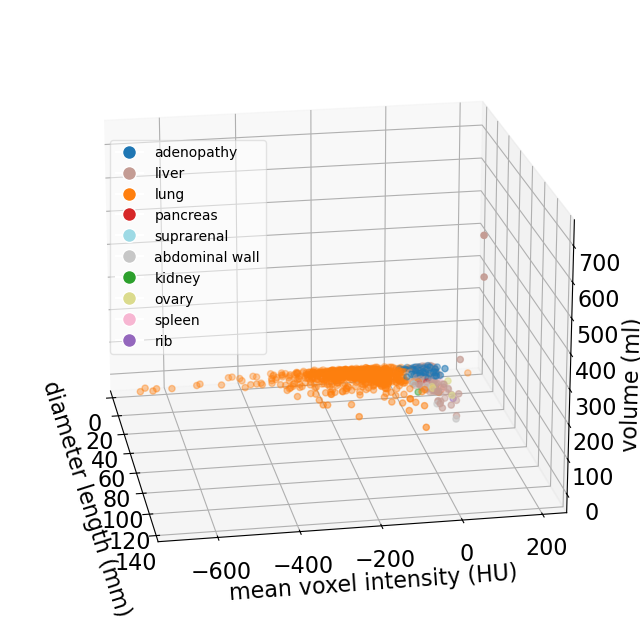

In [6]:
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(111, projection='3d')
cmap = colormaps['tab20']
unique_labels = lesions_df['scatterplot_category'].unique().tolist()

# Plot the scatter, with color mapping
colors = [
    cmap(idx / (len(unique_labels) - 1))
    for idx in range(len(unique_labels))
]
random.seed(80) # 6, 9, 13, 40, 60, 80
random.shuffle(colors)
first_color = colors.pop(0)
colors.insert(1, first_color)
color_mapping = {
    key: colors[idx]
    for idx, key in enumerate(unique_labels)
}
lesions_df['color_code'] = lesions_df['scatterplot_category'].apply(lambda x: color_mapping[x])
sc = ax.scatter(
    lesions_df['diameter_length'],
    lesions_df['mean_HU'],
    lesions_df['volume_ml'],
    c=lesions_df['color_code']
)

# Labels for axes
ax.set_xlabel('diameter length (mm)', labelpad=7)
ax.set_ylabel('mean voxel intensity (HU)', labelpad=7)
ax.set_zlabel('volume (ml)', labelpad=7)

# add legend
legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[label], markersize=10, label=label)
                  for label in unique_labels]
ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(0.15, 0.8), fontsize=10, framealpha=0.5)

# Show plot
ax.view_init(elev=20, azim=-10)
#plt.tight_layout()
if savefig:
    if not save_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'scatterplot_3d.png', transparent=True, bbox_inches='tight')
plt.show()

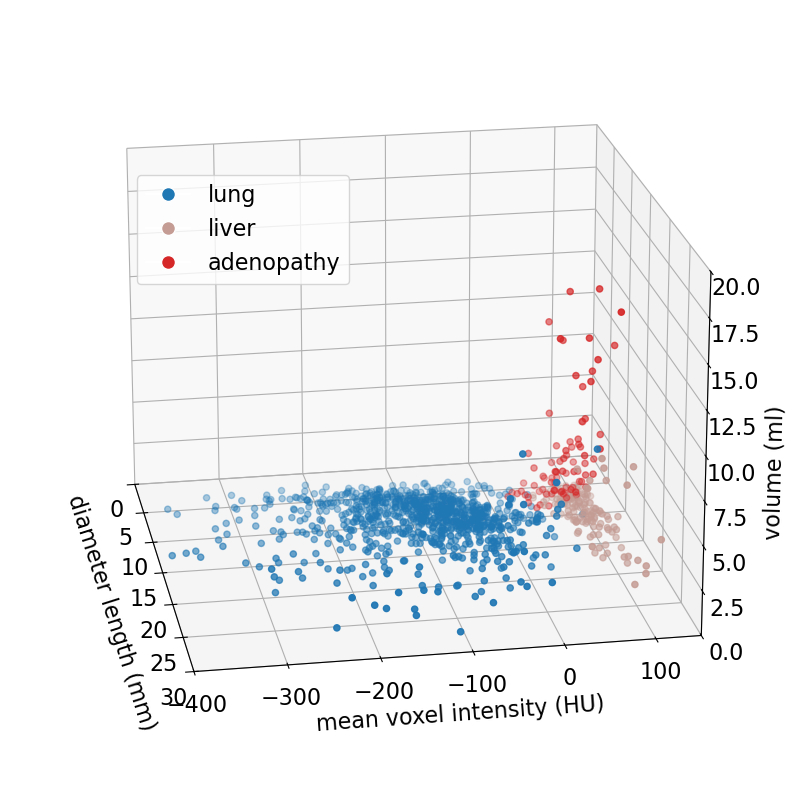

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')  # This implicitly uses Axes3D
cmap = colormaps['tab20']

lesions_df_subset = lesions_df[lesions_df['scatterplot_category'].isin(['lung', 'liver', 'adenopathy'])].copy()
unique_labels = lesions_df_subset['scatterplot_category'].unique().tolist()

# Feature range to display 
diameter_lims = (0, 30)
volume_lims = (0, 20)
hu_lims = (-400, 150)

# Plot the scatter, with color mapping
color_mapping = {
    key: color
    for key, color in color_mapping.items()
    if key in unique_labels
}
color_mapping = {
    'lung': '#1f77b4',
    'liver': '#c49c94',
    'adenopathy': '#d62728'
}
lesions_df_subset['color_code'] = lesions_df_subset['scatterplot_category'].apply(lambda x: color_mapping[x])
lesions_df_subset_to_display = lesions_df_subset[
    (lesions_df_subset['diameter_length'] > diameter_lims[0]) &
    (lesions_df_subset['diameter_length'] < diameter_lims[1]) &
    (lesions_df_subset['mean_HU'] > hu_lims[0]) &
    (lesions_df_subset['mean_HU'] < hu_lims[1]) &
    (lesions_df_subset['volume_ml'] > volume_lims[0]) &
    (lesions_df_subset['volume_ml'] < volume_lims[1])
].copy()
sc = ax.scatter(
    lesions_df_subset_to_display['diameter_length'],
    lesions_df_subset_to_display['mean_HU'],
    lesions_df_subset_to_display['volume_ml'],
    c=lesions_df_subset_to_display['color_code']
)

# Labels for axes
ax.set_xlabel('diameter length (mm)', labelpad=10)
ax.set_ylabel('mean voxel intensity (HU)', labelpad=10)
ax.set_zlabel('volume (ml)', labelpad=10)

# add legend
legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[label], markersize=10, label=label)
                  for label in ['lung', 'liver', 'adenopathy']]
ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(0.15, 0.8))

# Show plot
ax.view_init(elev=20, azim=-10) #azim:-60, -260, 270

# Set limits
ax.set_xlim(diameter_lims[0], diameter_lims[1])
ax.set_ylim(hu_lims[0], hu_lims[1])
ax.set_zlim(volume_lims[0], volume_lims[1])

if savefig:
    if not save_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'scatterplot_3d_lung_liver_adenopathy_zoomed.png', transparent=True, bbox_inches='tight')
    plt.savefig(Path.cwd() / 'results' / 'scatterplot_3d_lung_liver_adenopathy_zoomed.svg', transparent=True, bbox_inches='tight')
plt.show()

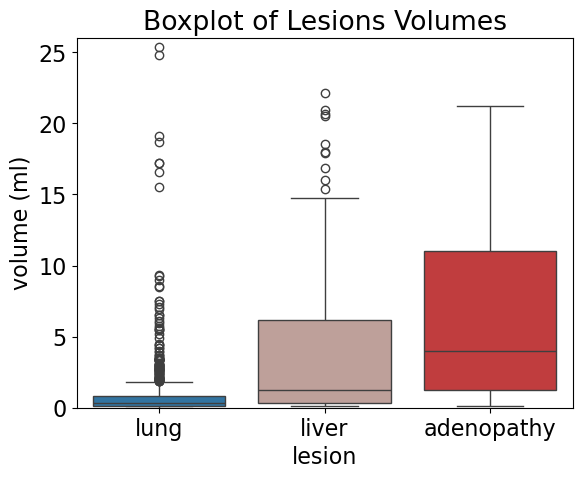

Volume (ml) stats all lesions
------------------------------


count    1246.000000
mean        4.870700
std        30.091480
min         0.014461
25%         0.188289
50%         0.468714
75%         1.374875
max       719.045727
Name: volume_ml, dtype: float64



Volume (ml) stats of subset
------------------------------


,count,mean,std,min,25%,50%,75%,max
scatterplot_category,,,,,,,,
adenopathy,93.0,14.299806,29.173599,0.146850,1.263431,3.963807,10.997623,145.312931
liver,192.0,16.450763,70.706086,0.098063,0.339467,1.214713,6.171058,719.045727
lung,939.0,1.039552,2.981793,0.014461,0.141703,0.351562,0.822944,42.792098


In [8]:
# Lesion volumes
sns.boxplot(
    data=lesions_df_subset,
    x='scatterplot_category',
    y='volume_ml',
    order=['lung', 'liver', 'adenopathy'],
    palette=color_mapping,
    hue='scatterplot_category',
    legend=False
)
plt.ylim((0, 26))
plt.xlabel('lesion')
plt.ylabel('volume (ml)')
plt.title('Boxplot of Lesions Volumes')
if savefig:
    if not save_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'lesions_volumes_distributions.png', bbox_inches='tight', transparent=True)
    plt.savefig(Path.cwd() / 'results' / 'lesions_volumes_distributions.svg', bbox_inches='tight', transparent=True)
plt.show()
print(f"Volume (ml) stats all lesions")
print(30 * '-')
display(lesions_df['volume_ml'].describe())
print('\n')
print(f"Volume (ml) stats of subset")
print(30 * '-')
display(lesions_df_subset.groupby('scatterplot_category')['volume_ml'].describe())

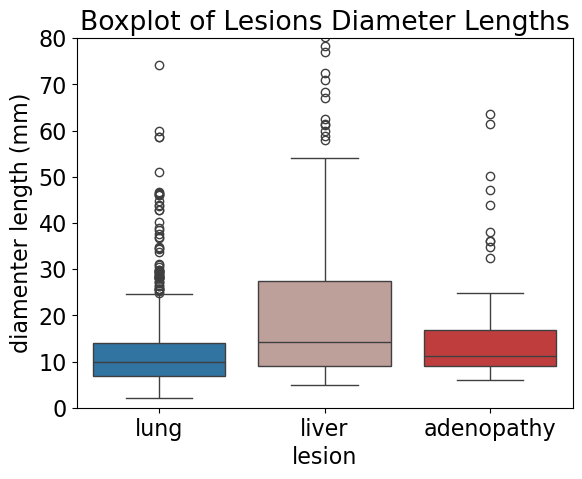

Diameter length (mm) stats all lesions
------------------------------


count    1246.000000
mean       14.178047
std        12.414282
min         2.109375
25%         7.357422
50%        10.606601
75%        15.876575
max       135.839255
Name: diameter_length, dtype: float64



Diameter length (mm) stats of subset
------------------------------


,count,mean,std,min,25%,50%,75%,max
scatterplot_category,,,,,,,,
adenopathy,93.0,15.717531,11.432585,5.917969,8.983674,11.220703,16.764996,63.620407
liver,192.0,22.066407,20.578608,5.021563,8.994141,14.278181,27.382812,135.839255
lung,939.0,11.889439,8.033439,2.109375,6.830078,9.822449,14.040170,74.162614


In [9]:
# Lesions diameters
sns.boxplot(
    data=lesions_df_subset,
    x='scatterplot_category',
    y='diameter_length',
    order=['lung', 'liver', 'adenopathy'],
    palette=color_mapping,
    hue='scatterplot_category',
    legend=False
)
plt.xlabel('lesion')
plt.ylabel('diamenter length (mm)')
plt.title('Boxplot of Lesions Diameter Lengths')
plt.ylim((0, 80))
if savefig:
    if not save_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'lesions_diameter_lengths_distributions.png', bbox_inches='tight', transparent=True)
    plt.savefig(Path.cwd() / 'results' / 'lesions_diameter_lengths_distributions.svg', bbox_inches='tight', transparent=True)
plt.show()
print(f"Diameter length (mm) stats all lesions")
print(30 * '-')
display(lesions_df['diameter_length'].describe())
print('\n')
print(f"Diameter length (mm) stats of subset")
print(30 * '-')
display(lesions_df_subset.groupby('scatterplot_category')['diameter_length'].describe())

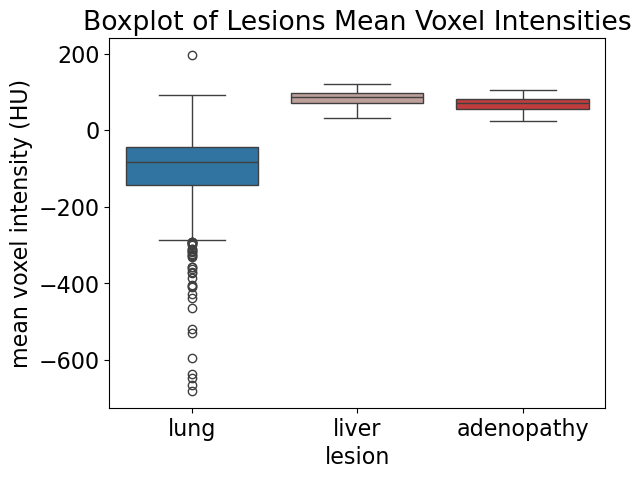

Mean voxel intensity (HU) stats all lesions
------------------------------


count    1246.000000
mean      -57.126257
std       111.833544
min      -680.534400
25%      -118.804088
50%       -55.944512
75%        34.433233
max       196.468120
Name: mean_HU, dtype: float64



Mean voxel intensity (HU) stats of subset
------------------------------


,count,mean,std,min,25%,50%,75%,max
scatterplot_category,,,,,,,,
adenopathy,93.0,67.795328,19.023966,23.533583,56.039204,69.749500,81.106590,104.755066
liver,192.0,84.312760,20.155389,33.061710,71.173217,86.757295,98.305472,120.371460
lung,939.0,-101.459006,91.978616,-680.534400,-141.790845,-83.264830,-43.979485,196.468120


In [10]:
# Lesions intensiteis (mean HU)
sns.boxplot(
    data=lesions_df_subset,
    x='scatterplot_category',
    y='mean_HU',
    order=['lung', 'liver', 'adenopathy'],
    palette=color_mapping,
    hue='scatterplot_category',
    legend=False
)
plt.xlabel('lesion')
plt.ylabel('mean voxel intensity (HU)')
plt.title('Boxplot of Lesions Mean Voxel Intensities')
if savefig:
    if not save_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'lesions_mean_HU_boxplots.png', bbox_inches='tight', transparent=True)
    plt.savefig(Path.cwd() / 'results' / 'lesions_mean_HU_boxplots.svg', bbox_inches='tight', transparent=True)
plt.show()
print(f"Mean voxel intensity (HU) stats all lesions")
print(30 * '-')
display(lesions_df['mean_HU'].describe())
print('\n')
print(f"Mean voxel intensity (HU) stats of subset")
print(30 * '-')
display(lesions_df_subset.groupby('scatterplot_category')['mean_HU'].describe())

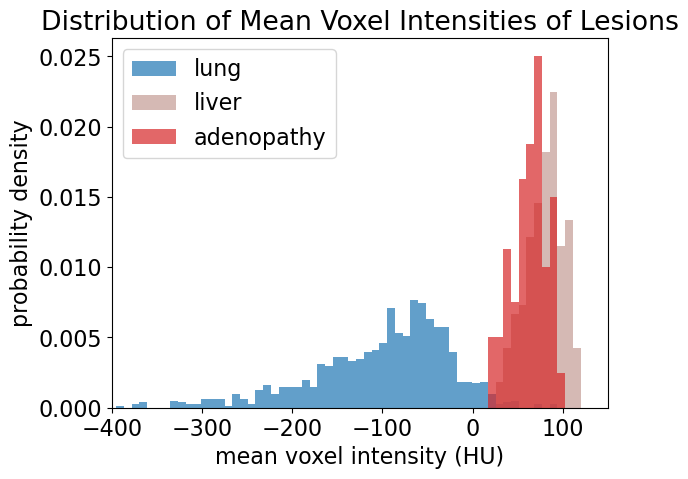

In [11]:
min_value = -700
max_value = 150
bins = 100
bin_edges = np.linspace(min_value, max_value, bins)
for category in ['lung', 'liver', 'adenopathy']:
    hist_values, _ = np.histogram(
        lesions_df_subset[lesions_df_subset['scatterplot_category'] == category]['mean_HU'],
        bins=bin_edges,
        density=True
    )
    plt.bar(
        bin_edges[:-1],
        hist_values,
        width=np.diff(bin_edges),
        alpha=0.7,
        label=category,
        color=color_mapping[category]
    )
plt.xlabel('mean voxel intensity (HU)')
plt.ylabel('probability density')
plt.title('Distribution of Mean Voxel Intensities of Lesions')
plt.xlim((-400, 150))
plt.legend()
if savefig:
    if not save_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'lesions_mean_HU_distributions.png', bbox_inches='tight', transparent=True)
    plt.savefig(Path.cwd() / 'results' / 'lesions_mean_HU_distributions.svg', bbox_inches='tight', transparent=True)
plt.show()    

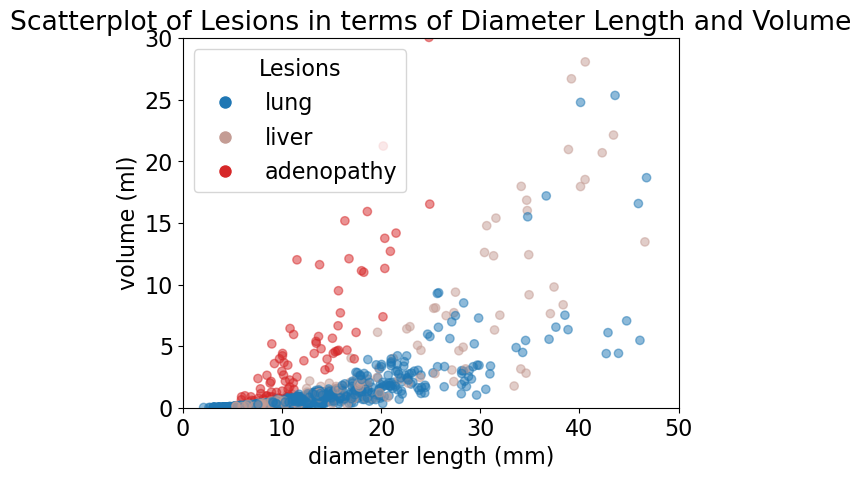

In [12]:
# Scatterplot of diameter length versus volume
_, ax = plt.subplots()
ax.scatter(
    lesions_df_subset['diameter_length'],
    lesions_df_subset['volume_ml'],
    alpha=0.5,
    c=lesions_df_subset['color_code']
)
#plt.xlim((0, 75))
#plt.ylim((0, 200))
plt.xlim((0, 50))
plt.ylim((0, 30))
plt.xlabel('diameter length (mm)')
plt.ylabel('volume (ml)')
plt.title("Scatterplot of Lesions in terms of Diameter Length and Volume")
# add legend
legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[label], markersize=10, label=label)
                  for label in ['lung', 'liver', 'adenopathy']]
ax.legend(handles=legend_patches, title="Lesions", loc='upper left')
if savefig:
    if not save_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'scatterplot_diameter_length_vs_volume.png', bbox_inches='tight', transparent=True)
plt.show()

In [13]:
# Spearman test (all lesions)
correlation, p_value = spearmanr(lesions_df["diameter_length"], lesions_df["volume_ml"])
print("Spearman test for all lesions")
print(30 * '-')
print(f"Spearman correlation: {correlation:.3f}")
print(f"p-value: {p_value}")
if p_value < 0.05:
    print("There is a statistically significant monotonic relationship between diameter and volume.")
else:
    print("There is no statistically significant monotonic relationship.")

# Spearman test (subset)
for category in unique_labels:
    correlation, p_value = spearmanr(
        lesions_df_subset[lesions_df_subset['scatterplot_category'] == category]["diameter_length"],
        lesions_df_subset[lesions_df_subset['scatterplot_category'] == category]["volume_ml"]
    )
    print('\n')
    print(f"Spearman test for {category}")
    print(30 * '-')
    print(f"Spearman correlation: {correlation:.3f}")
    print(f"p-value: {p_value}")
    if p_value < 0.05:
        print("There is a statistically significant monotonic relationship between diameter and volume.")
    else:
        print("There is no statistically significant monotonic relationship.")


Spearman test for all lesions
------------------------------
Spearman correlation: 0.917
p-value: 0.0
There is a statistically significant monotonic relationship between diameter and volume.


Spearman test for adenopathy
------------------------------
Spearman correlation: 0.906
p-value: 9.932655038180415e-36
There is a statistically significant monotonic relationship between diameter and volume.


Spearman test for liver
------------------------------
Spearman correlation: 0.957
p-value: 2.2508024130746316e-104
There is a statistically significant monotonic relationship between diameter and volume.


Spearman test for lung
------------------------------
Spearman correlation: 0.945
p-value: 0.0
There is a statistically significant monotonic relationship between diameter and volume.


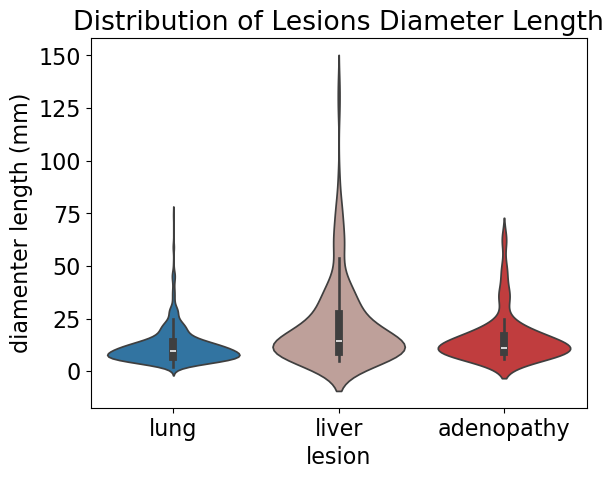

In [14]:
# Violin plots: diameter length
sns.violinplot(
    data=lesions_df_subset,
    x='scatterplot_category',
    y='diameter_length',
    order=['lung', 'liver', 'adenopathy'],
    palette=color_mapping,
    hue='scatterplot_category',
    legend=False
)
plt.xlabel('lesion')
plt.ylabel('diamenter length (mm)')
plt.title('Distribution of Lesions Diameter Length')
if savefig:
    if not save_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'violins_diameter_length.png', bbox_inches='tight', transparent=True)
plt.show()

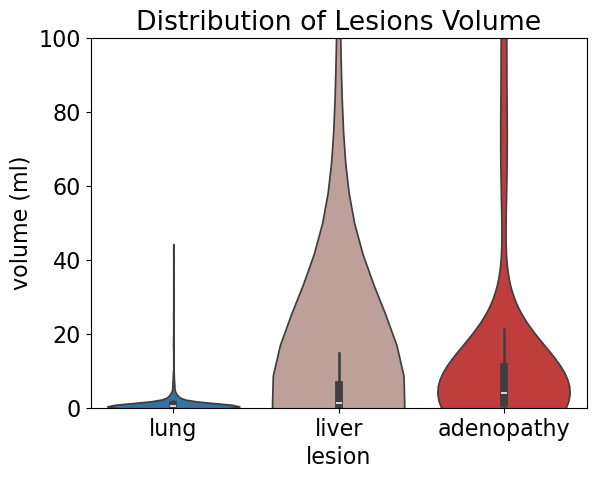

In [15]:
# Violin plots: volume
sns.violinplot(
    data=lesions_df_subset,
    x='scatterplot_category',
    y='volume_ml',
    order=['lung', 'liver', 'adenopathy'],
    palette=color_mapping,
    hue='scatterplot_category',
    legend=False
)
plt.xlabel('lesion')
plt.ylabel('volume (ml)')
plt.title('Distribution of Lesions Volume')
plt.ylim((0, 100))
if savefig:
    if not save_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'violins_volume.png', bbox_inches='tight', transparent=True)
plt.show()

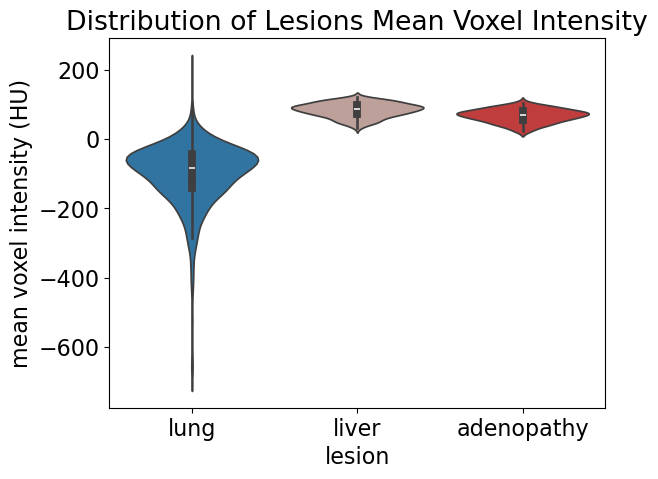

In [16]:
# Violin plots: mean voxel intensity
sns.violinplot(
    data=lesions_df_subset,
    x='scatterplot_category',
    y='mean_HU',
    palette=color_mapping,
    order=['lung', 'liver', 'adenopathy'],
    hue='scatterplot_category',
    legend=False
)
plt.xlabel('lesion')
plt.ylabel('mean voxel intensity (HU)')
plt.title('Distribution of Lesions Mean Voxel Intensity')
if savefig:
    if not save_title:
        plt.title('')
    plt.savefig(Path.cwd() / 'results' / 'violins_mean_HU.png', bbox_inches='tight', transparent=True)
plt.show()